# Process GPAHE data

In [1]:
import pandas as pd
import spacy
from IPython.display import Image
from wikidata.client import Client

In [2]:
SPACY_FIELD_NAMES = "DATE EVENT FAC GPE LANGUAGE LAW LOC MONEY NOMINAL NORP ORDINAL ORG PERCENT PERSON PRODUCT QUANTITY TIME WORK_OF_ART".split()

nlp = spacy.load('en_core_web_sm') 

In [3]:
DATA_FILE = "../../data/scraped_symbol_dict.json"
data_df = pd.read_json(DATA_FILE).T

## 1. Cluster hate symbols

Use https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html as example

In [4]:
import matplotlib.pyplot as plt
import regex
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import word_tokenize

In [5]:
def get_text_data(data_df):
    texts = []
    for _, row in data_df.iterrows():
        description = row["Description"]
        ideology = "# Ideology is " + regex.sub(",", " # Ideology is", row["Ideology"])
        location = "# Location is " + regex.sub(",", " # Location is", row["Location"])
        texts.append(" ".join(word_tokenize(" ".join([description, ideology, location]))))
    return texts

Interesting words for clustering:
* chapter
* club/klub
* group
* organization
* party
* proud (boys)

In [6]:
def vectorize_text_data(texts, nbr_of_dimensions=5):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(texts)
    vectorized_data = TruncatedSVD(n_components=nbr_of_dimensions, n_iter=5, random_state=42)
    vectorized_data.fit(X.T)
    return vectorized_data

In [7]:
def visualize(texts, vectorized_data, labels, dimension_1=0, dimension_2=1):
    try:
        x = vectorized_data.components_[dimension_1]
        y = vectorized_data.components_[dimension_2]
    except:
        raise ValueError(f"invalid pair of dimensions ({dimension_1}, {dimension_2})")
    split_data, labels = split_data_by_content(x, y, texts, labels)
    plt.figure(figsize=(24, 12))
    for color in sorted(split_data.keys(), reverse=True):
        plt.scatter(split_data[color][0], split_data[color][1], c=color, label=color, alpha=0.5)
    for i in range(0, len(x)):
        plt.annotate(str(i), (x[i], y[i]))
    plt.legend(labels=[ label for color, label in sorted(labels.items(), reverse=True) ] )
    plt.title(f"{len(x)} hate symbols clustered by description, ideology and location")
    plt.savefig("gpahe_process.png")
    plt.show()

In [8]:
red_token = "proud boys"
orange_token = "chapter"
yellow_token = "club"
green_token = "group"
other_color = "blue"
labels = { "yellow": yellow_token, "red": red_token, "orange": orange_token, "green": green_token, other_color: "other" }

def split_data_by_content(x, y, texts, labels):
    split_data = { other_color: [[], []], "green": [[], []], "orange": [[], []], "red": [[], []], "yellow": [[], []] }
    for i in range(0, len(x)):
        if regex.search(red_token, texts[i], regex.IGNORECASE):
            split_data["red"][0].append(x[i])
            split_data["red"][1].append(y[i])
        elif regex.search(orange_token, texts[i], regex.IGNORECASE):
            split_data["orange"][0].append(x[i])
            split_data["orange"][1].append(y[i])
        elif regex.search(yellow_token, texts[i], regex.IGNORECASE):
            split_data["yellow"][0].append(x[i])
            split_data["yellow"][1].append(y[i])
        elif regex.search(green_token, texts[i], regex.IGNORECASE):
            split_data["green"][0].append(x[i])
            split_data["green"][1].append(y[i])
        else:
            split_data[other_color][0].append(x[i])
            split_data[other_color][1].append(y[i])
    for color in labels:
        labels[color] += f" ({len(split_data[color][0])})"
    return split_data, labels

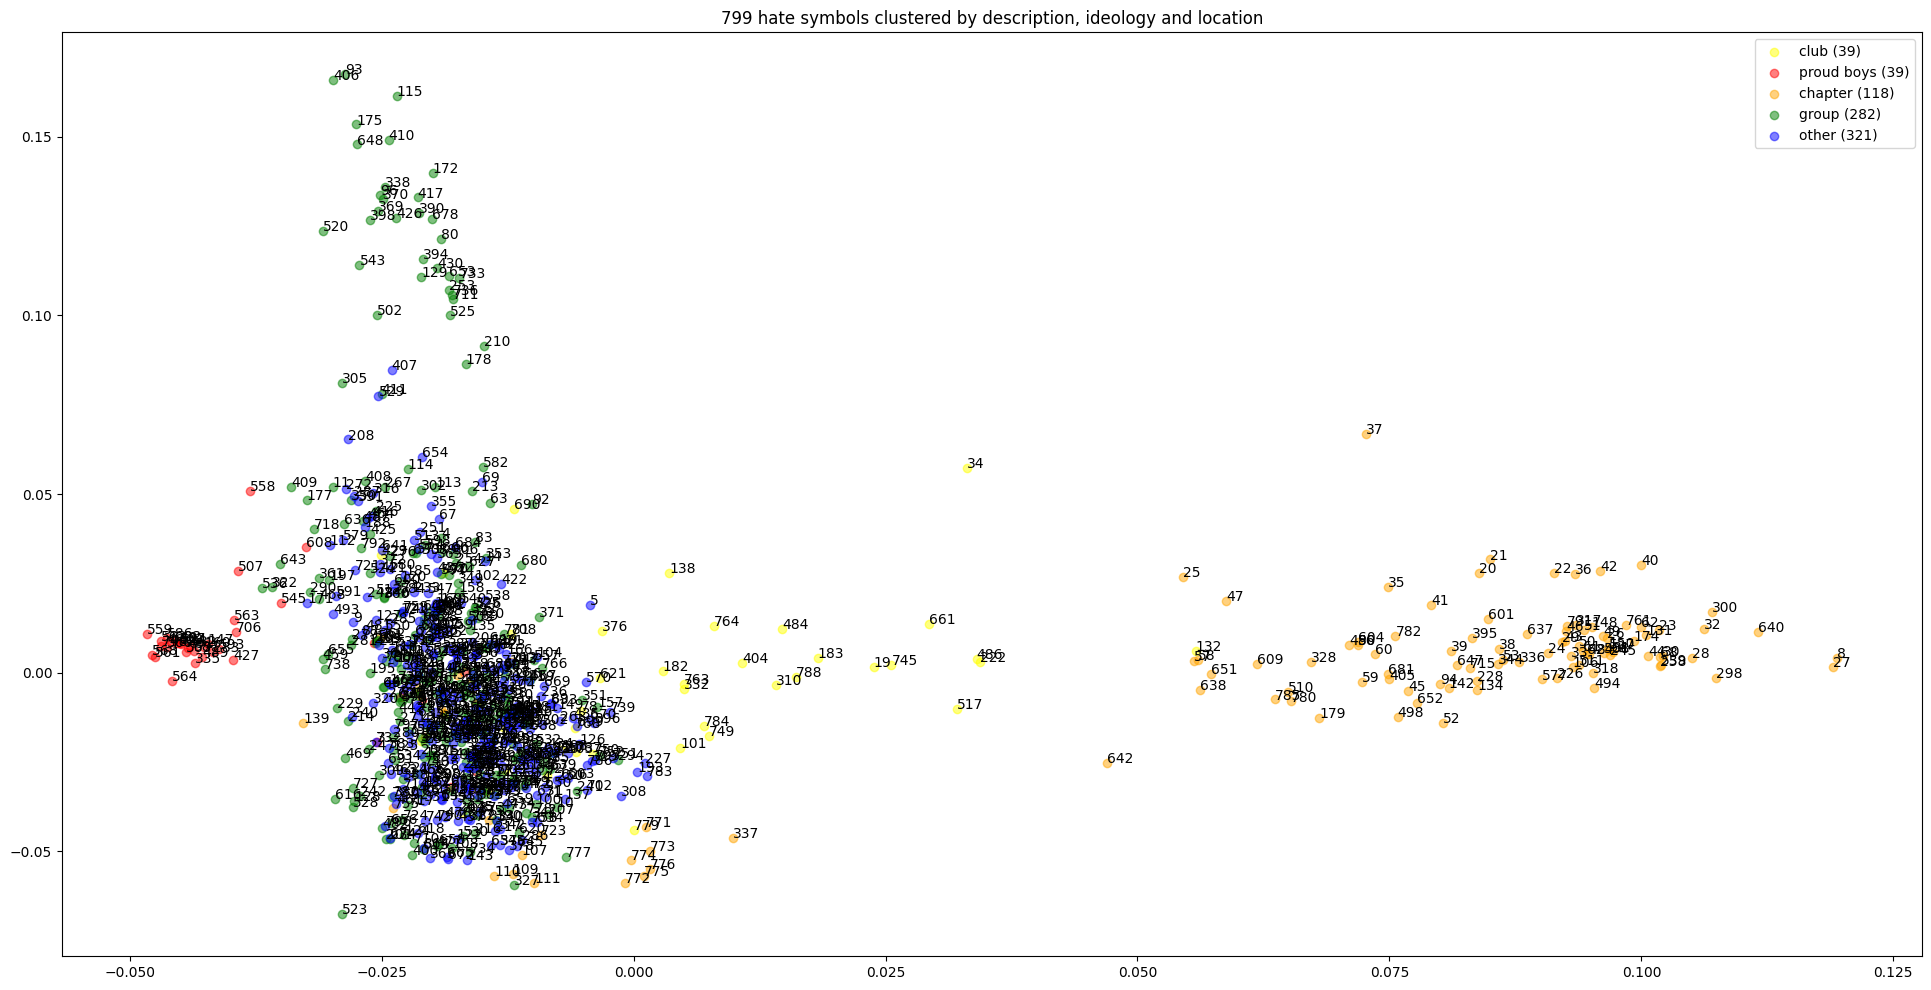

In [9]:
texts = get_text_data(data_df)
vectorized_data = vectorize_text_data(texts)
visualize(texts, vectorized_data, labels.copy(), dimension_1=1, dimension_2=3)

In [ ]:
data_df.iloc[422]["Description"]

## 2. Make a knowledge base

* https://medium.com/nlplanet/building-a-knowledge-base-from-texts-a-full-practical-example-8dbbffb912fa
* https://neo4j.com/blog/text-to-knowledge-graph-information-extraction-pipeline/
* https://neo4j.com/developer-blog/construct-knowledge-graphs-unstructured-text/
* https://towardsdatascience.com/how-to-convert-any-text-into-a-graph-of-concepts-110844f22a1a

## 3. Identify and count entities in description

In [ ]:
def get_entities(nlp_analysis):
    entities = {}
    for entity in nlp_analysis.ents:
        if entity.label_ not in entities:
            entities[entity.label_] = []
        entities[entity.label_].append(entity.text)
    return entities

In [ ]:
def add_nlp_analysis(data_df, nlp):
    entity_data = []
    for index, row in data_df.iterrows():
        nlp_analysis = nlp(row["Description"]) 
        entities = get_entities(nlp_analysis)
        entity_data.append(entities)
    data_df["entities"] = entity_data
    return data_df

In [ ]:
data_nlp_df = add_nlp_analysis(data_df, nlp)

In [ ]:
def count(data_nlp_df, field_name, n=10):
    values = {}
    for field_values in data_nlp_df["entities"]:
        if field_name in field_values:
            for field_value in field_values[field_name]:
                if field_value in values:
                    values[field_value] += 1
                else:
                    values[field_value] = 1
    print(f"{field_name} ({sum(values.values())}):", [[key, value] for key, value in sorted(values.items(), key=lambda item: item[1], reverse=True)][:n])

In [ ]:
for field_name in SPACY_FIELD_NAMES:
    count(data_nlp_df, field_name)

In [ ]:
count(data_nlp_df, "organizations")

In [ ]:
count(data_nlp_df, "locations")

In [ ]:
count(data_nlp_df, "events")

In [ ]:
count(data_nlp_df, "dates")

## 4. Link to wikidata (fails)

In [ ]:
client = Client()  # doctest: +SKIP
entity = client.get('Q20145', load=True)

In [ ]:
entity

In [ ]:
import pywikibot
from pywikibot import pagegenerators, WikidataBot

In [ ]:
sparql = "SELECT ?item WHERE { ?item rdfs:label 'Google'@en }"
entities = pagegenerators.WikidataSPARQLPageGenerator(sparql)
entities = list(entities)

## 5. download logo's manually (lot of work)

In [ ]:
from bs4 import BeautifulSoup
import urllib.request
import webbrowser

In [ ]:
base_url = "https://symbols.globalextremism.org/details?recordId="

In [ ]:
COUNTER_MINIMUM = 50
counter = 0
for id in data_df.index:
    counter += 1
    if counter > COUNTER_MINIMUM:
       webbrowser.open(base_url + id, new=2)
       print(counter)
       input()

1. open the web page in a new tab of a browser
2. right click on the logo/image
3. open the image in a new tab of the browser
4. right click on the image
5. save the image with name number.extension
6. close the two added tabs
7. push the enter/return button on the notebook page
8. repeat for the next logo/image